### Advertising Promotion Optimization - A/B testing and Client Targeting


#### Background Information

The dataset provided in this project was originally used as a take-home assignment provided by Starbucks for their job candidates. The data consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

The task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, the goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).


#### How To Test The Strategy?

When reaching an optimization strategy, the `promotion_strategy` function will be run to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well the promotion strategy will work in the future. 

Each strategy will be tested against the test dataset used in the final `test_results` function.

<h2>Table of Contents</h2>
<ol>
    <a href = '#ab'><li><b>Checking A/B Test</b></li></a>
        <ol>
            <a href = '#inva'><li><b>Invariant Metric</b></li></a>
            <a href = '#eval'><li><b>Evaluation Metric</b></li></a>
        </ol>
    <a href = '#analysis'><li><b>Exploratory Analysis</b></li></a>
        <ol>
            <a href = '#corr'><li><b>Correlation</b></li></a>
                <ol>
                    <a href = '#corranal'><li><b>Considerations on Correlation Analysis</b></li></a>
                </ol>
            <a href = '#hist'><li><b>Histogram</b></li></a>
                <ol>
                    <a href = '#histanal'><li><b>Considerations on Histogram Analysis</b></li></a>
                </ol>
        </ol>
    <a href = '#start'><li><b>Starting Parameters</b></a>
        <ol>
            <a href = '#appr1'><li><b>All the Clients</b></li></a>
            <a href = '#appr2'><li><b>Client Segmentation Using Individual Correlation</b></li></a>
        </ol>
    <a href = '#diff'><li><b>Testing Different Approaches</b></a>
        <ol>
            <a href = '#appr3'><li><b>Logistic Regression</b></li></a>
            <a href = '#appr4'><li><b>XGBoost Classifier</b></li></a>
                <ol>
                    <a href = '#appr40'><li><b>Basic Approach</b></li></a>
                    <a href = '#appr41'><li><b>Manipulating Features - Approach 1</b></li></a>
                    <a href = '#appr42'><li><b>Manipulating Features - Approach 2</b></li></a>
                    <a href = '#appr43'><li><b>Manipulating Features - Approach 3</b></li></a>
                </ol>
        </ol>
     <a href = '#conclusion'><li><b>Conclusion</b></li></a>
</ol>

In [1]:
# load in packages
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

from imblearn.over_sampling import SMOTENC, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the data:
train_data = pd.read_csv('training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


<h2>Checking A/B Test</h2>
<p>
    Since we are dealing with the results of the A/B test applied, we are going to run a statistical test over both invariant and experimental metrics - in this case, number of clients assigned to the control and the experimental groups and the number of purchases for each group respectively.
</p>
<p>
    In both tests, we are going to consider a significance of 5%.
</p>
<h3>Invariant Metric</h3>
<p>
    First, let's check whether or not the invariant metric (number os clients designated to control and experimental groups) is statistically equal by computing the p-value when comparing the two groups:
</p>

In [3]:
# number of clients designated to each group in training set:
train_data.Promotion.value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [4]:
# expected probability when randomly designating clients to promotion and non-promotion groups:
mean = 0.5

# creating experiment list:
exp_list = [1 if x == 'Yes' else 0 for x in train_data.Promotion]

# computing sample mean:
s_mean = (np.sum(exp_list) + 0.5) / len(exp_list)

# computing standard deviation:
s_std = np.std(exp_list)

# computing z score:
z_im = (s_mean - mean) / (s_std / np.sqrt(len(exp_list)))
print('Z score for the invariant metric is {:.2f}'.format(z_im))

Z score for the invariant metric is 0.67


In [5]:
# computing p-value:
p_value_im = sp.stats.norm.cdf(-z_im)
print('Invariant metric: p-value is {:.2f}, which means we failed to reject null hypothesis.'.format(p_value_im))

Invariant metric: p-value is 0.25, which means we failed to reject null hypothesis.


<h3>Evaluation Metric</h3>
<p>
    Once the composition of control and experimental groups is considered statistically correct, we're are going to check if the experiment resulted effectively in increasing the number of purchases in comparison to the control group:
</p>

In [6]:
# experimental group size:
n1 = np.sum(exp_list)

# control group size:
n0 = len(exp_list) - n1

# purchase overall mean:
p_null = train_data.purchase.mean()

# purchase mean in control group:
p0 = train_data[train_data.Promotion == 'No'].purchase.mean()

# purchase mean in experimental group:
p1 = train_data[train_data.Promotion == 'Yes'].purchase.mean()

# computing standard error:
se = np.sqrt(p_null * (1-p_null) * (1/n0 + 1/n1))

# computing z score:
z_em = (p1 - p0) / se
print('Z score for the experimental metric is {:.2f}'.format(z_em))

Z score for the experimental metric is 12.47


In [7]:
# computing p-value:
p_value_em = sp.stats.norm.cdf(-z_em)
print('Experimental metric: p-value is {:.2f}, which means that we can reject null hypthesis with over 95% of confidence.'.format(p_value_em))

Experimental metric: p-value is 0.00, which means that we can reject null hypthesis with over 95% of confidence.


<h2>Exploratory Analysis</h2>
<p>
    In the experiment, the promotion was randomly sent to Starbucks' clients. The goal is to use the data collected to improve the strategy by sending the promotion only to the ones who are more likely to use it.
</p>
<p>
    In other words, we need to differenciate customers that would buy the product <b>because of the promotion</b> from the ones that would buy it even if they didn't get the promotion and the group that wouldn't buy it despite of any promotion.
</p>

In [8]:
# general statistical overview:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [9]:
# checking for null values:
train_data.isnull().mean()

ID           0.0
Promotion    0.0
purchase     0.0
V1           0.0
V2           0.0
V3           0.0
V4           0.0
V5           0.0
V6           0.0
V7           0.0
dtype: float64

In [10]:
# purchase count in control group:
train_data[train_data.Promotion == 'No'].purchase.value_counts()

0    41851
1      319
Name: purchase, dtype: int64

In [11]:
# purchase count in experimental group:
train_data[train_data.Promotion == 'Yes'].purchase.value_counts()

0    41643
1      721
Name: purchase, dtype: int64

<h3>Correlation</h3>

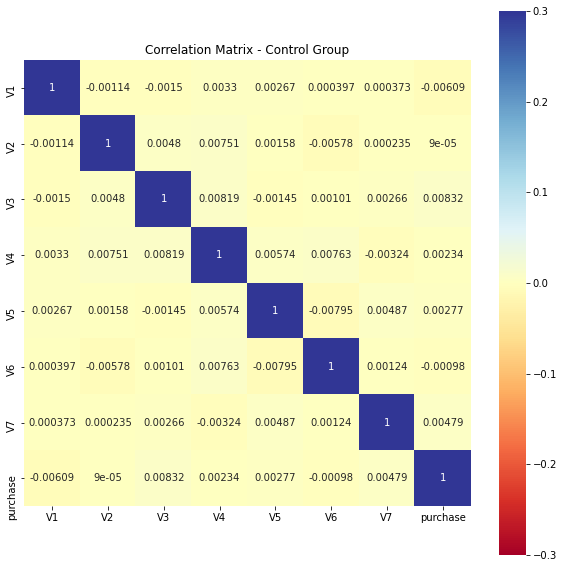

In [12]:
# filtering data for control group:
control = train_data[train_data.Promotion == 'No']
sel_features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'purchase']

# evaluating features' correlation for experimental group:
contr_corr = control[sel_features].corr()

# creating correlation plot:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10))

sns.heatmap(contr_corr, annot = True, fmt = '.3g', vmin = -.3, vmax = .3, center = 0, 
                        cmap = 'RdYlBu', square = True)
ax.set_title('Correlation Matrix - Control Group')

fig.show()

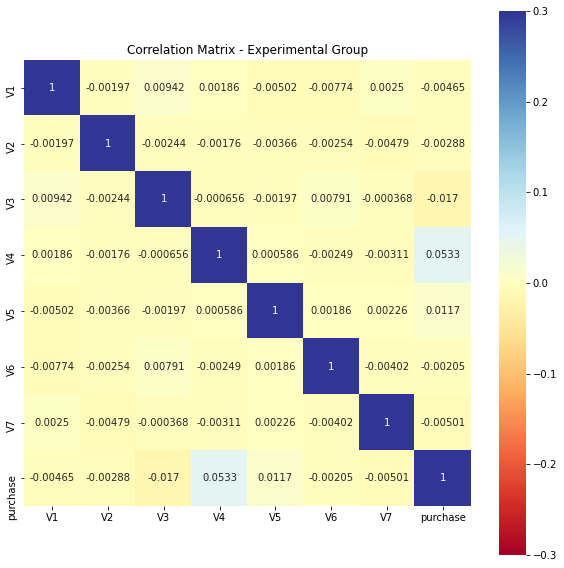

In [13]:
# filtering data for experimental group:
experimental = train_data[train_data.Promotion == 'Yes']

# evaluating features' correlation for experimental group:
exper_corr = experimental[sel_features].corr()

# creating correlation plot:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10))

sns.heatmap(exper_corr, annot = True, fmt = '.3g', vmin = -.3, vmax = .3, center = 0, 
                        cmap = 'RdYlBu', square = True)
ax.set_title('Correlation Matrix - Experimental Group')

fig.show()

In [14]:
# observing the percentage variation in the correlation between control and experimental group: 
purch_corr = pd.DataFrame()
purch_corr['control'] = contr_corr['purchase']
purch_corr['experimental'] = exper_corr['purchase']
purch_corr['perc_var'] = -((purch_corr.control - purch_corr.experimental)/purch_corr.control)*100
purch_corr

,control,experimental,perc_var
V1,-0.006088,-0.004651,-23.605724
V2,0.000090,-0.002885,-3306.003045
V3,0.008325,-0.017012,-304.357526
V4,0.002344,0.053348,2176.227435
V5,0.002771,0.011711,322.600958
V6,-0.000980,-0.002049,109.222660
V7,0.004786,-0.005005,-204.587034
purchase,1.000000,1.000000,-0.000000


<p>
    It's interesting to observe that, considering the only difference between control and experimental groups is whether or not they were given a promotion ticket, among the features with higher correlation, the one that was most responsive to the experiment is represented by <b>V4</b>.
</p>
<p>
    V4 already had a positive correlation with the purchase feature, considering the control group. With the promotion event, its positive correlation increased by over 2000%, which is impressive. Considering the ideal experiment, where all the other variables are controlled, we could say that the higher V4 is, the more susceptible the client is to use the promotion and purchase the product. Since V4 is a binary feature (1 or 2), we can translate it as <b>class 2</b> being more receptive to the promotion event.
</p>
<p>
    <b>V5</b> behaves the same as V4, but with lower intensity. In the control group, it already showed a positive correlation with the purchase, and this correlation was powered with the promotion, increasing by over 300%. V5 represents categories from 1 to 4, indicating that categories represented by higher numbers tend to be more affected by the promotion, in a positive way.
</p>
<p>
    A different response is shown when observing the <b>V3</b> feature. In the control group, this variable represented the highest positive correlation, while in the experimental group this tendency was reversed: it became the second-highest correlation score, and this time in a negative direction. It looks like clients related to higher values of V3 have a naturally higher propensity for purchasing the product. At the same time, these clients are not quite receptive to promotional events.
</p>
<p>
    Other features like <b>V2</b> show a great variation when comparing control and experimental groups. However, they don't stand out because their correlation values are too low in comparison to the other features.
</p>
<h4>Considerations on Correlation Analysis</h4>
<p>
    Just by looking at the correlation values for both groups, we could say that, in general, clients that belong to class 2 in feature V4, higher classes in V5, and are related to lower V3 values are the clients with more potential of being positively responsive to the promotion. 
</p>
<p>
    Also, we could see that clients associated with higer values of V3 seems to be more willing to purchase the product, despite any promotional event. Actually, promotional events seem to cause negative impact on their interest in purchasing the product.
</p>
<p>
    At the same time, since even the highest correlation values represent in fact low correlation, we have to say that there must be other important clients' aspects not being captured by these features that affect the positive or negative responses to the promotional event.
</p>

<h3>Histogram</h3>

Histograms for Control Group V1-V7 
red: no-purchase | blue: purchase


array([[<AxesSubplot:title={'center':'V5'}>,
        <AxesSubplot:title={'center':'V6'}>,
        <AxesSubplot:title={'center':'V7'}>]], dtype=object)

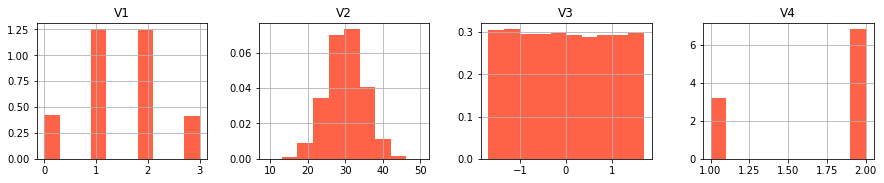

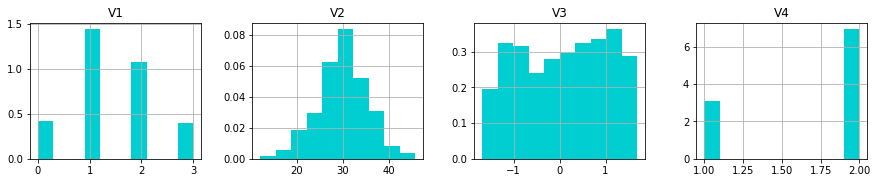

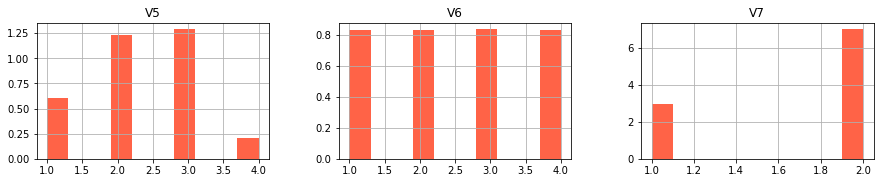

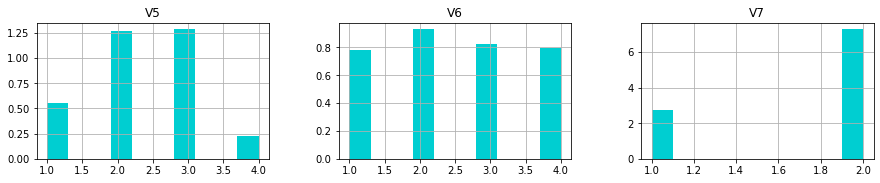

In [15]:
# Defining features:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

# Features histograms for control group:
print('Histograms for Control Group V1-V7 \nred: no-purchase | blue: purchase')
control[control.purchase == 0].hist(column = features[:4], figsize=(15,2.5), layout = (1, 4), 
                                    density = True, color = 'tomato')

control[control.purchase == 1].hist(column = features[:4], figsize=(15,2.5), layout = (1, 4), 
                                              density = True, color = 'darkturquoise')

control[control.purchase == 0].hist(column = features[4:], figsize=(15,2.5), layout = (1, 3), 
                                    density = True, color = 'tomato')

control[control.purchase == 1].hist(column = features[4:], figsize=(15,2.5), layout = (1, 3), 
                                              density = True, color = 'darkturquoise')

<p>
    In the <b>control group</b>, we can see some differences between the ones who purchased the product or not. For example, people related to the class 1 in the V1 feature seem to be more likely to purchase the product in comparison to the other classes.
</p>
<p>
    V3 reinforces what we concluded from the correlation analysis: clients with higher V3 values are more likely to buy the product without any promotional event.
</p>
<p>
    V6 shows a slightly advantage in class 2 as a trend for naturally purchasing the product.
</p>

Histograms for Experimental Group V1-V7 
red: no-purchase | blue: purchase


array([[<AxesSubplot:title={'center':'V5'}>,
        <AxesSubplot:title={'center':'V6'}>,
        <AxesSubplot:title={'center':'V7'}>]], dtype=object)

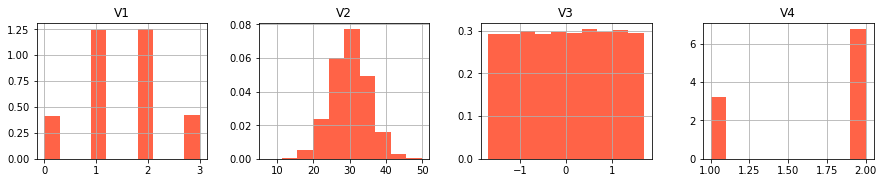

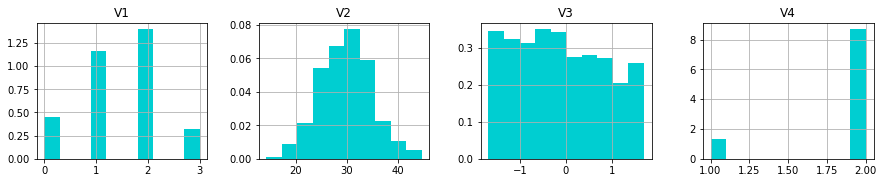

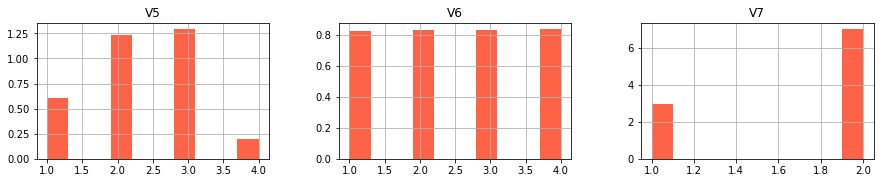

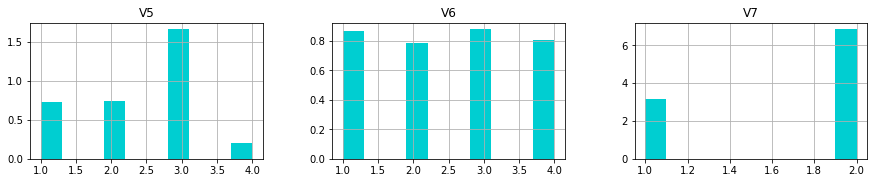

In [16]:
# Features histograms for experimental group:
print('Histograms for Experimental Group V1-V7 \nred: no-purchase | blue: purchase')
experimental[experimental.purchase == 0].hist(column = features[:4], figsize=(15,2.5), layout = (1, 4), 
                                    density = True, color = 'tomato')

experimental[experimental.purchase == 1].hist(column = features[:4], figsize=(15,2.5), layout = (1, 4), 
                                              density = True, color = 'darkturquoise')

experimental[experimental.purchase == 0].hist(column = features[4:], figsize=(15,2.5), layout = (1, 3), 
                                    density = True, color = 'tomato')

experimental[experimental.purchase == 1].hist(column = features[4:], figsize=(15,2.5), layout = (1, 3), 
                                              density = True, color = 'darkturquoise')

<p>
    In the <b>experimental group</b> we can see some interesting changes. In V1, for example, the trend presented by class 1 in the control group is reverted, since proportionally class 2 increases its participation with the promotion, and class 1 decreases the participation among the buyers.
</p>
<p>
    V2 shows that clients with values closer to the mean are more responsive to the promotion.
</p>
<p>
    Again, we can see through V3 that its distribution resembles a mirrored-image of the control group, considering the ones who purchased the product. In other words, lower values of V3 represent consumers that purchase the product because of the promotion, while higher values of V3 represent consumers that are discouraged to buy the product because of the promotion.
</p>
<p>
    Class 1 in V4 tends to be not responsive to the promotional event, as well as class 2 in V6 and more significantly in the V5 feature. In the other hand, class 3 in V5 seems to increase its purchase rate with the promotional event.
</p>

<h4>Considerations on Histogram Analysis</h4>
<p>
    We could reinforce some of the conclusions settled before, and we could see some changes in the behavior of the clients depending on whether they were submitted to the promotional event or not.
</p>
<p>
    Although we don't know exactly what each feature is representing, I would guess that V2 represents something like ages, being that the subjects who are around their thirties tend to be more responsive to the promotion.
</p>
<p>
    V3 could easily represent the subject's incomes, once the ones who have higher incomes would buy the product whenever they wanted to, and the ones with lower incomes would increase their purchases once they were exposed to some promotional event.
</p>

<h2>Starting Parameters</h2>
<p>
    Once we have identified one consumer's potential profile that is more receptive to the promotion offer, let's simply test what would be the test result if we sent the promotion to:
<ol type="1">
    <li>all the clients;</li>
    <li>the clients within features' values with higher positive correlation.</li>
</ol>
</p>

<h3>Approach 1 - All the Clients</h3>

In [17]:
# Defining function to test promotion to all the clients:
def promotion_strategy_all(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    prom_list = ['Yes' for i in range(df.shape[0])]
    
    promotion = np.array(prom_list)
    
    return promotion

# Testing IRR and NIR for this strategy:
test_results(promotion_strategy_all)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009593158278250108, -1132.1999999999998)

<p>
    As expected, the strategy of sending the promotion to all the clients does not optimize <i>Incremental Response Rate</i> nor <i>Net Incremented Revenue</i>.
</p>

<h3>Approach 2 - Client Segmentation Using Individual Correlation</h3>

In [18]:
# Defining function using Correlation for client segmentation:
def promotion_strategy_corr(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    prom_list = ['Yes' if (df.V4.iloc[i] == 2) | (df.V5.iloc[i] >= 3) else 'No' for i in range(df.shape[0])]
    
    promotion = np.array(prom_list)
    
    return promotion

# Testing IRR and NIR for this strategy:
test_results(promotion_strategy_corr)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0119.

Your nir with this strategy is -531.40.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01191694716124083, -531.4000000000001)

<p>
    In comparison to the first approach, this simple client segmentation based on individual feature correlation already showed some advances. Still, we need to test approaches that consider the incremental contribution of each one of the features acting together.
</p>

<h2>Testing Different Approaches</h2>
<h3>Approach 3 - Logistic Regression</h3>
<p>
    In this approach, we are going to train a logistic regression model to predict whether or not a client should be sent the promotion: we are only using the experimental group, considering the ones who made the purchase as the group that should recieve the promotion.
</p>

In [19]:
# Selecting training set:
X = experimental[features]
y = experimental['purchase']

# Balancing train set with SMOTE:
smotenc = SMOTENC(categorical_features = [0, 3, 4, 5, 6], random_state = 101)
X_bal, y_bal = smotenc.fit_sample(X, y)
print(y_bal.value_counts())

# Training Logistic Regression model, using GridSearchCV for best parameters:
lr = LogisticRegression()
param = {'penalty': ['l1', 'l2'], 
         'C': [1, 10, 100]}
log_r_cv = GridSearchCV(lr, param_grid = param)
log_r_cv.fit(X_bal, y_bal)

0    41643
1    41643
Name: purchase, dtype: int64


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1, 10, 100], 'penalty': ['l1', 'l2']})

In [20]:
# Defining function using Logistic Regression for client segmentation:
def promotion_strategy_log(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    X_test = df[features]
    y_pred = log_r_cv.predict(X_test)
    prom_list = ['Yes' if y_pred[i] == 1 else 'No' for i in range(len(y_pred))]
    
    promotion = np.array(prom_list)
    
    return promotion

# Testing IRR and NIR for this strategy:
test_results(promotion_strategy_log)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0145.

Your nir with this strategy is -72.55.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.014468322486757366, -72.54999999999995)

<p>
    <b>Logistic Regression</b> improved our previous correlation approach, but it's not a good model yet.
</p>
<p>
    Let's check for most important features using Decision Tree algorithm:
</p>

In [21]:
# Training Decision Tree Classifier to check for most important features:
tree = DecisionTreeClassifier(random_state = 101)
tree.fit(X_bal, y_bal)

# Checking feature importance
feature_imp = tree.feature_importances_
for i, value in zip(np.argsort(-feature_imp), -np.sort(-feature_imp)):
    print(features[i], round(value, 2))

V3 0.52
V2 0.2
V4 0.09
V5 0.07
V6 0.05
V1 0.04
V7 0.03


<p>
    Next step, let's try the same Logistic Regression approach, this time selecting only the 4 most important variables to see if it improves the model:
</p>

In [22]:
# Selecting training set:
features_imp = ['V2', 'V3', 'V4', 'V5']
X_imp = experimental[features_imp]
y_imp = experimental['purchase']

# Balancing train set with SMOTE:
smotenc_imp = SMOTENC(categorical_features = [2, 3], random_state = 201)
X_ibal, y_ibal = smotenc_imp.fit_sample(X_imp, y_imp)
print(y_ibal.value_counts())

# Training Logistic Regression model, using GridSearchCV for best parameters:
log_r_cv_imp = GridSearchCV(lr, param_grid = param)
log_r_cv_imp.fit(X_ibal, y_ibal)

0    41643
1    41643
Name: purchase, dtype: int64


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1, 10, 100], 'penalty': ['l1', 'l2']})

In [23]:
def promotion_strategy_log_imp(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    X_test = df[features_imp]
    y_pred = log_r_cv_imp.predict(X_test)
    prom_list = ['Yes' if y_pred[i] == 1 else 'No' for i in range(len(y_pred))]
    
    promotion = np.array(prom_list)
    
    return promotion

# Testing IRR and NIR for this strategy:
test_results(promotion_strategy_log_imp)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0147.

Your nir with this strategy is -39.60.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.0147094528569421, -39.59999999999991)

<p>
    Feature selection did improve the model, however, we couldn't achieve our purposes yet.
</p>

<h3>Approach 4 - XGBoost Classifier</h3>
<h4>Basic Approach</h4>
<p>
    Up until now, we have trained the models using only our experimental group. In this fourth approach, let's try one kind of one-versus-rest classification.
</p>
<p>
    In this attempt, let's consider that only the ones who recieved the promotion and purchased the product build the features' composition of those who should recieve the promotion. All the other clients represent the profile that should not recieve the promotion:
</p>

In [24]:
# Selecting training set:
data_xgb = train_data[features]

# Transforming labels:
data_xgb['send_prom'] = [1 if (train_data.Promotion.iloc[i] == 'Yes') & (train_data.purchase.iloc[i] == 1) else 0 \
                         for i in range(train_data.shape[0])]
data_xgb.head()

,V1,V2,V3,V4,V5,V6,V7,send_prom
0,2,30.443518,-1.165083,1,1,3,2,0
1,3,32.159350,-0.645617,2,3,2,2,0
2,2,30.431659,0.133583,1,1,4,2,0
3,0,26.588914,-0.212728,2,1,4,2,0
4,3,28.044331,-0.385883,1,1,2,2,0


In [25]:
# Applying SMOTE:
smotenc_xgb = SMOTENC(categorical_features = [0, 3, 4, 5, 6], random_state = 301)
X_xgb, y_xgb = smotenc_xgb.fit_sample(data_xgb[features], data_xgb['send_prom'])
print(y_xgb.value_counts())

# Training XGBClassifier model:
xgb = XGBClassifier(objective = 'binary:logistic', seed = 301, verbosity = 0)
param_xgb = {'learning_rate': [0.1, 0.3], 'max_depth': [5, 7], 
             'min_child_weight': [1, 5], 'reg_lambda': [1, 5], 'gamma': [.1, 3, 5]}

xgb_cl = GridSearchCV(xgb, param_grid = param_xgb, scoring = 'roc_auc')
xgb_cl.fit(X_xgb, y_xgb)

0    83813
1    83813
Name: send_prom, dtype: int64


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=301,
                                     subsample=None, tree_method=None,
        

In [26]:
# Defining function using XGBClassifier for client segmentation:
def promotion_strategy_xgb(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    X_test = df[features]
    y_pred = xgb_cl.predict(X_test)
    prom_list = ['Yes' if y_pred[i] == 1 else 'No' for i in range(len(y_pred))]
    
    promotion = np.array(prom_list)
    
    return promotion

# Testing IRR and NIR for this strategy:
test_results(promotion_strategy_xgb)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0164.

Your nir with this strategy is -1.10.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.016444154998371867, -1.1000000000000014)

<p>
    <b>XGBoost Classifier</b> improved our <i>IRR</i> and <i>NIR</i> metrics, but the last one still needs improvement.
</p>
<h4>Manipulating Features - Approach 1</h4>
<p>
    In the next trial, let's transform the continuous numeric variables into classes distributed as observerd during the histogram analysis to see if it improves the generalization. Once again, let's use only the experimental group:
</p>

In [27]:
# Selecting data and applying transformations:
data_xgb2 = experimental[sel_features]
# Transforming V2 and V3:
V2_cat = [0 if ((data_xgb2.V2.iloc[i] < 20) | (data_xgb2.V2.iloc[i] > 40)) \
          else 1 if (20 <= data_xgb2.V2.iloc[i] < 25) \
          else 2 if (25 <= data_xgb2.V2.iloc[i] < 30) \
          else 3 if (30 <= data_xgb2.V2.iloc[i] < 35) \
          else 4 for i in range(data_xgb2.shape[0])]
data_xgb2['V2'] = V2_cat
V3_cat = [5 if (data_xgb2.V3.iloc[i] <= -1) \
          else 4 if (-1 < data_xgb2.V3.iloc[i] <= -0.5) \
          else 3 if (-0.5 < data_xgb2.V3.iloc[i] <= 0) \
          else 2 if (0 < data_xgb2.V3.iloc[i] <= 0.5) \
          else 1 if (0.5 < data_xgb2.V3.iloc[i] <= 1) \
          else 0 for i in range(data_xgb2.shape[0])]
data_xgb2['V3'] = V3_cat
data_xgb2.head()

,V1,V2,V3,V4,V5,V6,V7,purchase
4,3,2,3,1,1,2,2,0
8,2,3,2,2,3,1,2,0
10,1,3,5,2,1,4,1,0
12,1,4,2,2,3,1,1,0
14,3,4,4,2,2,4,1,0


In [28]:
# Applying SMOTE:
smote_xgb2 = SMOTE(random_state = 1001)
X_xgb2, y_xgb2 = smote_xgb2.fit_sample(data_xgb2[features], data_xgb2['purchase'])
print(y_xgb2.value_counts())

# Training XGBClassifier model:
xgb = XGBClassifier(objective = 'binary:logistic', seed = 1001, verbosity = 0)
param_xgb = {'learning_rate': [0.1, 0.3], 'max_depth': [3, 5], 
             'min_child_weight': [1, 5], 'reg_lambda': [1, 5], 'gamma': [.1, 3, 5]}

xgb_cl2 = GridSearchCV(xgb, param_grid = param_xgb, scoring = 'roc_auc')
xgb_cl2.fit(X_xgb2, y_xgb2)

0    41643
1    41643
Name: purchase, dtype: int64


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=1001,
                                     subsample=None, tree_method=None,
       

In [29]:
# Defining function using XGBClassifier for client segmentation:
def promotion_strategy_xgb2(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    X_test = df[features]
    V2_cat = [0 if ((X_test.V2.iloc[i] < 20) | (X_test.V2.iloc[i] > 40)) \
              else 1 if (20 <= X_test.V2.iloc[i] < 25) \
              else 2 if (25 <= X_test.V2.iloc[i] < 30) \
              else 3 if (30 <= X_test.V2.iloc[i] < 35) \
              else 4 for i in range(X_test.shape[0])]
    X_test['V2'] = V2_cat
    V3_cat = [5 if (X_test.V3.iloc[i] <= -1) \
              else 4 if (-1 < X_test.V3.iloc[i] <= -0.5) \
              else 3 if (-0.5 < X_test.V3.iloc[i] <= 0) \
              else 2 if (0 < X_test.V3.iloc[i] <= 0.5) \
              else 1 if (0.5 < X_test.V3.iloc[i] <= 1) \
              else 0 for i in range(X_test.shape[0])]
    X_test['V3'] = V3_cat
    y_pred = xgb_cl2.predict(X_test)
    prom_list = ['Yes' if y_pred[i] == 1 else 'No' for i in range(len(y_pred))]
    
    promotion = np.array(prom_list)
    
    return promotion

# Testing IRR and NIR for this strategy:
test_results(promotion_strategy_xgb2)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0178.

Your nir with this strategy is 153.70.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.017830221770241402, 153.70000000000005)

<p>
    We can see that this strategy did optimize our metrics, not as good as Starbucks itself, but still a significant improvement.
</p>
<p>
    Our understanding of the behavior of the features during the exploratory analysis was fundamental to elaborate this strategy. We are going to keep this same approach, now generalizing a little bit more the classes we created before.
</p>
<h4>Manipulating Features - Approach 2</h4>
<p>
    Considering the V2 feature distribution, it looks like there is a similar response to the promotion along with its values with slight differences. Still, the largest proportion of clients is situated around the mean value - like a traditional Gaussian distribution. With that in mind, let's try to focus on the greatest public 'cutting off' the tails in one single group.
</p>
<p>
    At the same time, we are simplifying V3 classes as an attempt to make them more generalistic:
</p>

In [30]:
data_xgb3 = experimental[sel_features]
data_xgb3['V2'] = [0 if ((data_xgb3.V2.iloc[i] < 15) | (data_xgb3.V2.iloc[i] > 45)) \
                   else 1 for i in range(data_xgb3.shape[0])] 

data_xgb3['V3'] = [-1 if (data_xgb3.V3.iloc[i] > 1) \
                   else 0 if (0 <= data_xgb3.V3.iloc[i] <= 1) \
                   else 1 if (-1 <= data_xgb3.V3.iloc[i] < 0) \
                   else 2 for i in range(data_xgb3.shape[0])] 
data_xgb3.head()

,V1,V2,V3,V4,V5,V6,V7,purchase
4,3,1,1,1,1,2,2,0
8,2,1,0,2,3,1,2,0
10,1,1,2,2,1,4,1,0
12,1,1,0,2,3,1,1,0
14,3,1,1,2,2,4,1,0


In [31]:
# Applying SMOTE:
smotenc_xgb3 = SMOTE(random_state = 401)
X_xgb3, y_xgb3 = smotenc_xgb3.fit_sample(data_xgb3[features], data_xgb3['purchase'])
print(y_xgb3.value_counts())

# Training XGBClassifier model:
xgb = XGBClassifier(objective = 'binary:logistic', seed = 401, verbosity = 0)
param_xgb = {'learning_rate': [0.1, 0.3], 'max_depth': [3, 5], 
             'min_child_weight': [1, 5], 'reg_lambda': [1, 5], 'gamma': [.1, 3, 5]}

xgb_cl3 = GridSearchCV(xgb, param_grid = param_xgb, scoring = 'roc_auc')
xgb_cl3.fit(X_xgb3, y_xgb3)

0    41643
1    41643
Name: purchase, dtype: int64


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=401,
                                     subsample=None, tree_method=None,
        

In [32]:
# Defining function using XGBClassifier for client segmentation:
def promotion_strategy_xgb3(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    X_test = df[features]
    X_test['V2'] = [0 if ((X_test.V2.iloc[i] < 15) | (X_test.V2.iloc[i] > 45)) \
                    else 2 for i in range(X_test.shape[0])]
    X_test['V3'] = [-1 if (X_test.V3.iloc[i] > 1) \
                    else 0 if (0 <= X_test.V3.iloc[i] <= 1) \
                    else 1 if (-1 <= X_test.V3.iloc[i] < 0) \
                    else 2 for i in range(X_test.shape[0])]
    y_pred = xgb_cl3.predict(X_test)
    prom_list = ['Yes' if y_pred[i] == 1 else 'No' for i in range(len(y_pred))]
    
    promotion = np.array(prom_list)
    
    return promotion

# Testing IRR and NIR for this strategy:
test_results(promotion_strategy_xgb3)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0173.

Your nir with this strategy is 154.00.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.017338303174019454, 154.0)

<p>
    We can see that this more generalist strategy came up with similar results.
</p>
<h4>Manipulating Features - Approach 3</h4>
<p>
    As a next attempt, we are going to distinguish the classes not only by their distributions and importances, but the classes' values are going to represent some kind of <b>weight</b> according to their relevance when considering the ones who purchased the product in the experimental group:
</p>

In [33]:
# Selecting data and applying transformations:
data_xgb4 = experimental[sel_features]
# Transforming V2 and V3:
data_xgb4['V2'] = [0 if ((data_xgb4.V2.iloc[i] < 15) | (data_xgb4.V2.iloc[i] > 45)) \
                   else 1 if ((15 <= data_xgb4.V2.iloc[i] < 25) | (35 < data_xgb4.V2.iloc[i] <= 45)) \
                   else 2 for i in range(data_xgb4.shape[0])]

data_xgb4['V3'] = [3 if (data_xgb4.V3.iloc[i] <= -1) \
                   else 2 if (-1 < data_xgb4.V3.iloc[i] <= -0.5) \
                   else 1 if (-0.5 < data_xgb4.V3.iloc[i] <= 0) \
                   else -1 if (0 < data_xgb4.V3.iloc[i] <= 0.5) \
                   else -2 if (0.5 < data_xgb4.V3.iloc[i] <= 1) \
                   else -3 for i in range(data_xgb4.shape[0])]
data_xgb4.head()

,V1,V2,V3,V4,V5,V6,V7,purchase
4,3,2,1,1,1,2,2,0
8,2,2,-1,2,3,1,2,0
10,1,2,3,2,1,4,1,0
12,1,1,-1,2,3,1,1,0
14,3,1,2,2,2,4,1,0


In [34]:
# Applying SMOTE:
smote_xgb4 = SMOTE(random_state = 1001)
X_xgb4, y_xgb4 = smote_xgb4.fit_sample(data_xgb4[features], data_xgb4['purchase'])
print(y_xgb4.value_counts())

# Training XGBClassifier model:
xgb = XGBClassifier(objective = 'binary:logistic', seed = 1001, verbosity = 0)
param_xgb = {'learning_rate': [0.1, 0.3], 'max_depth': [3, 5], 
             'min_child_weight': [1, 5], 'reg_lambda': [1, 5], 'gamma': [.1, 3, 5]}

xgb_cl4 = GridSearchCV(xgb, param_grid = param_xgb, scoring = 'roc_auc')
xgb_cl4.fit(X_xgb4, y_xgb4)

0    41643
1    41643
Name: purchase, dtype: int64


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=1001,
                                     subsample=None, tree_method=None,
       

In [35]:
# Defining function using XGBClassifier for client segmentation:
def promotion_strategy_xgb4(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    X_test = df[features]
    V2_cat = [0 if ((X_test.V2.iloc[i] < 15) | (X_test.V2.iloc[i] > 45)) \
              else 1 if ((15 <= X_test.V2.iloc[i] < 25) | (35 < X_test.V2.iloc[i] <= 45)) \
              else 2 for i in range(X_test.shape[0])]
    X_test['V2'] = V2_cat
    V3_cat = [3 if (X_test.V3.iloc[i] <= -1) \
              else 2 if (-1 < X_test.V3.iloc[i] <= -0.5) \
              else 1 if (-0.5 < X_test.V3.iloc[i] <= 0) \
              else -1 if (0 < X_test.V3.iloc[i] <= 0.5) \
              else -2 if (0.5 < X_test.V3.iloc[i] <= 1) \
              else -3 for i in range(X_test.shape[0])]
    X_test['V3'] = V3_cat
    y_pred = xgb_cl4.predict(X_test)
    prom_list = ['Yes' if y_pred[i] == 1 else 'No' for i in range(len(y_pred))]
    
    promotion = np.array(prom_list)
    
    return promotion

# Testing IRR and NIR for this strategy:
test_results(promotion_strategy_xgb4)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0185.

Your nir with this strategy is 214.70.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01849462654235275, 214.70000000000005)

<p>
    In this last approach, we finally achieved results that overcome the ones given by Starbucks. While our <i>irr</i> has a similar value in comparison to Starbucks's model, our <i>nir</i> showed a great improvement, close to 15%.
</p>

<h2>Conclusion</h2>
<p>
    We could see through this project the importance of data analysis in Data Science projects. Even when it's not clear what a feature represents, through the analysis process we were able to guess what some features could represent, and more importantly how they related to our business problem.
</p>
<p>
    Understanding how differently these features behave when comparing our study groups made it possible to elaborate different feature engineering strategies that resulted in better optimization.
</p>
<p>
    The most successful model came up with this strategy:
    <li>V2 was separated into classes labeled with the weight of their occurrences in the dataset, following a normal distribution;</li>
    <li>V3 was separated into 6 classes, lower values were labeled with higher numbers since they represent the ones who are more likely to respond to the promotional event;</li>
</p>
<p>
    Besides that, we could guess that that V2 probably represents clients' age, while V3 stands for their incomes.
</p>